# CSN8010 Practical Lab 3 Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

**Student Name: Hasyashri Bhatt**

**Student ID:9028501**

---

# **Introduction:**

We are trying to teach a computer to look at a picture and say whether it's a dog or a cat. This is done using a technique called Deep Learning.

There are two parts to this assignment:

- Build our own model (from scratch, called a "Vanilla CNN")
- Use a pre-trained model (VGG16 — a very smart model trained by researchers on millions of images), and fine-tune it.

We'll then compare the results and draw conclusions.

---

## The Dogs vs. Cats Dataset

* [Published](https://www.microsoft.com/en-us/research/publication/asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization/) in 2007 by Microsoft.
* This dataset appears in Chollet, Deep Learing with Python 2nd edition, chapter 8 (book and associated notebook). 

The dataset can be obtained from:
* [Dogs versus Cats](https://www.kaggle.com/c/dogs-vs-cats) - The Kaggle competition
* [The Dataset](https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats) (with an Open Data license)

1. Download the dataset from Kaggle.
2. Extracted `train.zip` into a folder of your choice.  You should have **25,000** images, of about 600MB. The folder could be part of the repository, e.g.  `./data/kaggle_dogs_vs_cats/` . By the way, if you save it in the `./data/` folder it won't be tracked with Git, given that this folder appears in the `.gitignore` file. This is preferred, since `Git` and `Github` are not intended as data repositories.
3. The following code to create a small dataset of 1000 training images, 500 validation images and 1000 test images *per class*. This reduces the dataset from 25,000 images to 5000.
4. I manually delete the larger dataset as well as the zip file.

# Step 1: Loaded Data:

Originally dataset was 25000 images so I ran below code to create smaller dataset which is about 5000 images.and after I commented this codeblock to avoid use of original dataset.

In [ ]:

#import os, shutil, pathlib
#from PIL import Image

#original_dir = pathlib.Path("./data/kaggle_dogs_vs_cats/train")
#new_base_dir = pathlib.Path("./data/kaggle_dogs_vs_cats_small")
#target_size = (224, 224)

#def make_subset(subset_name, start_index, end_index):
    #for category in ("cat", "dog"):
        #dir = new_base_dir / subset_name / category
        #os.makedirs(dir)
        #fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        #for fname in fnames:
           #src_path = original_dir / fname
           #dst_path = dir / fname
           #with Image.open(src_path) as img:
                #img = img.convert("RGB").resize(target_size)
                #img.save(dst_path)
#make_subset("train", start_index=0, end_index=1000)
#make_subset("validation", start_index=1000, end_index=1500)
#make_subset("test", start_index=1500, end_index=2500)


**Dataset Preparation and Resizing**

The original Dogs vs Cats dataset contains images of varying sizes and large file size. To make the dataset more manageable for training and sharing (e.g., uploading to GitHub), I created a smaller subset containing 5000 images (2500 cats and 2500 dogs) with the following steps:

- Selected 5000 images from the original dataset.
- Resized all images to 224×224 pixels to ensure uniform input size for CNN models like Vanilla CNN and 
  VGG16.
- Saved the resized images in a new folder structure:
- kaggle_dogs_vs_cats_small/train/cat, kaggle_dogs_vs_cats_small/train/dog, etc.

The resizing significantly reduced the total dataset size, bringing it under 100MB without compromising image quality necessary for model training.

This smaller dataset is optimized for efficient training and easy sharing without losing the essential features for classification.

- Training set (2,000 images: 1,000 cats, 1,000 dogs) – what the model learns from.
- Validation set (1,000 images) – to check how well the model is learning during training.
- Test set (2,000 images) – to test the model at the end, like a final exam.

And resized all images to 224×224 pixels (required for VGG16).

----

# Step 2: Exploratory Data Analysis (EDA)


What Is EDA?
Exploratory Data Analysis (EDA) is like getting to know your data before starting the actual work. Think of it like checking your ingredients before cooking.

In [ ]:
## Import necessary libraries
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

base_dir = "./data/kaggle_dogs_vs_cats_small"


In [11]:
#  Step 1: Create DataFrame with image metadata
def create_image_dataframe(base_dir, sample_size=200):
    data = []
    for subset in ["train", "validation", "test"]:
        for label in ["cat", "dog"]:
            folder = os.path.join(base_dir, subset, label)
            filenames = os.listdir(folder)[:sample_size // 6]
            for fname in filenames:
                path = os.path.join(folder, fname)
                try:
                    with Image.open(path) as img:
                        img = img.convert("RGB")
                        width, height = img.size
                        mode = img.mode
                        mean_pixel = np.mean(np.array(img))
                        data.append({
                            "filename": fname,
                            "subset": subset,
                            "label": label,
                            "width": width,
                            "height": height,
                            "mode": mode,
                            "mean_pixel_value": mean_pixel
                        })
                except:
                    continue
    return pd.DataFrame(data)

df_images = create_image_dataframe(base_dir)
print(f"Total images: {len(df_images)}")




Total images: 198


**Explaination:**

The code samples about 33 images from each of 6 groups (3 subsets × 2 labels), resulting in 198 images total. This is why the output shows "Total images: 198" instead of 200—due to integer division and equal distribution across groups.

In [12]:

# Step 2: Show statistics (image shape, color mode, pixel intensity)
print("=== Dataset Overview ===")
print(df_images["label"].value_counts())
print("\n=== Subset Distribution ===")
print(df_images["subset"].value_counts())
print("\n=== Color Modes ===")
print(df_images["mode"].value_counts())



=== Dataset Overview ===
label
cat    99
dog    99
Name: count, dtype: int64

=== Subset Distribution ===
subset
train         66
validation    66
test          66
Name: count, dtype: int64

=== Color Modes ===
mode
RGB    198
Name: count, dtype: int64


**Explaination:**

**Dataset Overview:**
- The dataset is perfectly balanced with 99 images each of cats and dogs.
**Subset Distribution:**
- The images are evenly split across the three subsets — 66 images in train, validation, and test each.
**Color Modes:**
- All images are in RGB color mode, confirming consistent color format throughout the dataset.

In [13]:
#  Step 3: Summary statistics (image size, pixel values)
print("\n=== Numeric Summary ===")
print(df_images.describe())


=== Numeric Summary ===
       width  height  mean_pixel_value
count  198.0   198.0        198.000000
mean   224.0   224.0        114.352976
std      0.0     0.0         25.845491
min    224.0   224.0         53.546011
25%    224.0   224.0         97.163008
50%    224.0   224.0        111.326278
75%    224.0   224.0        128.745302
max    224.0   224.0        198.502843


**Explaination:**

This table shows basic statistics about the images in the sample. All images are 224×224 pixels, so width and height are always 224. The average brightness (mean pixel value) is about 114, with most images ranging from 54 to 199. This means the images have similar sizes and a moderate range of brightness levels.

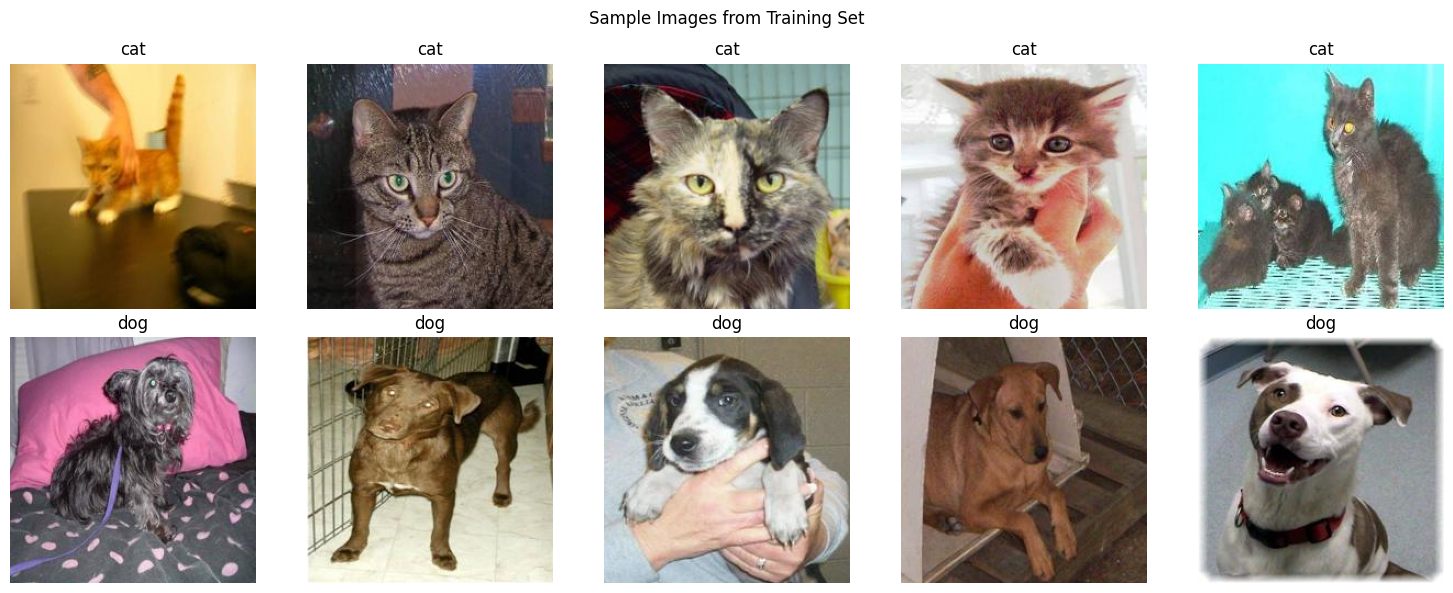

In [14]:
#  Step 4: Visualize sample images
def show_sample_images(base_dir):
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    for i, category in enumerate(["cat", "dog"]):
        folder = os.path.join(base_dir, "train", category)
        sample_files = os.listdir(folder)[:5]
        for j, img_name in enumerate(sample_files):
            img_path = os.path.join(folder, img_name)
            img = Image.open(img_path)
            axs[i, j].imshow(img)
            axs[i, j].set_title(f"{category}")
            axs[i, j].axis("off")
    plt.suptitle("Sample Images from Training Set")
    plt.tight_layout()
    plt.show()

show_sample_images(base_dir)


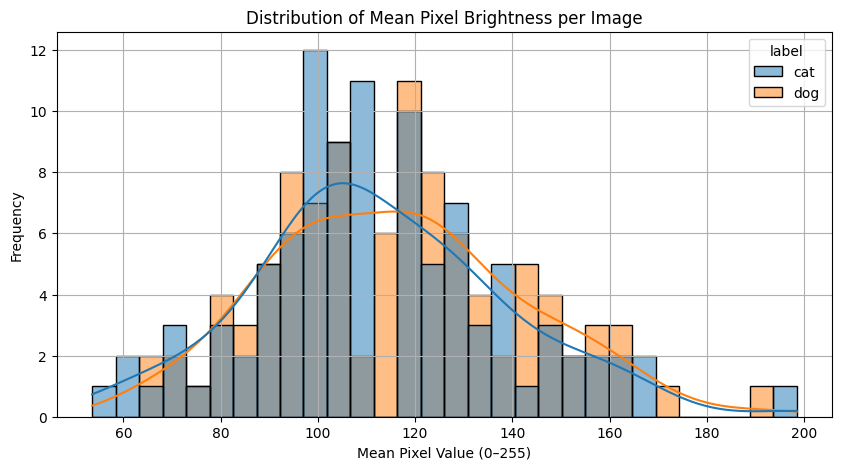

In [15]:
#  Step 5: Visualize pixel intensity distribution
plt.figure(figsize=(10, 5))
sns.histplot(data=df_images, x="mean_pixel_value", hue="label", bins=30, kde=True)
plt.title("Distribution of Mean Pixel Brightness per Image")
plt.xlabel("Mean Pixel Value (0–255)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

**Explaination**

This graph shows the distribution of average pixel brightness per image for cats and dogs. Most images fall between brightness values of 90 and 130, with cat images slightly darker on average. There’s a large overlap between the two classes, suggesting brightness alone isn’t a strong feature for classification. However, the plot helps identify potential dataset bias or preprocessing needs, like normalization, to ensure fair model training.

# Step 3: Build a Vanilla CNN (from scratch)

**What is a CNN?**
A Convolutional Neural Network (CNN) is a special type of model used to work with images. It learns to detect shapes, edges, colors — and finally, what is in the image (cat or dog).

**Steps:**
- Used layers like Conv2D, MaxPooling2D, Flatten, and Dense
- Used Adam optimizer
- Used ModelCheckpoint to save the best version of the model

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

def build_vanilla_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification: dog or cat
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [17]:
# Model summary for Vanilla CNN
vanilla_cnn = build_vanilla_cnn()
vanilla_cnn.summary()

c:\Users\habha\Downloads\lab 3 vanilaa CNN and vgg 16\Practical3_Vanilla_CNN_and_vgg16\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

**Explaination**

This CNN model processes 224×224 RGB images through three convolution and pooling layers to extract features, then flattens the output and passes it through two dense layers for binary classification (e.g., cat vs. dog). Most of the model's 11 million parameters come from the large dense layer after flattening. The final output layer has one neuron with likely a sigmoid activation for binary prediction.

### Train the model:

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'validation'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

model = build_vanilla_cnn()
checkpoint_cb = callbacks.ModelCheckpoint("vanilla_best.h5", save_best_only=True)



history = model.fit(train_generator, epochs=10,
                    validation_data=val_generator,
                    callbacks=[checkpoint_cb])


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


c:\Users\habha\Downloads\lab 3 vanilaa CNN and vgg 16\Practical3_Vanilla_CNN_and_vgg16\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\habha\Downloads\lab 3 vanilaa CNN and vgg 16\Practical3_Vanilla_CNN_and_vgg16\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.5030 - loss: 1.1990

63/63 ━━━━━━━━━━━━━━━━━━━━ 64s 974ms/step - accuracy: 0.5030 - loss: 1.1934 - val_accuracy: 0.5310 - val_loss: 0.6928
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 844ms/step - accuracy: 0.5656 - loss: 0.6917

63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 957ms/step - accuracy: 0.5656 - loss: 0.6916 - val_accuracy: 0.5970 - val_loss: 0.6783
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - accuracy: 0.6269 - loss: 0.6690

63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 908ms/step - accuracy: 0.6264 - loss: 0.6691 - val_accuracy: 0.6020 - val_loss: 0.6736
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 898ms/step - accuracy: 0.6434 - loss: 0.6399 - val_accuracy: 0.6090 - val_loss: 0.6819
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 909ms/step - accuracy: 0.7060 - loss: 0.5441 - val_accuracy: 0.6140 - val_loss: 0.7573
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 971ms/step - accuracy: 0.8107 - loss: 0.4133 - val_accuracy: 0.6240 - val_loss: 0.8103
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 925ms/step - accuracy: 0.9007 - loss: 0.2369 - val_accuracy: 0.6030 - val_loss: 0.9761
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 934ms/step - accuracy: 0.9605 - loss: 0.1337 - val_accuracy: 0.6200 - val_loss: 1.6344
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 954ms/step - accuracy: 0.9824 - loss: 0.0633 - val_accuracy: 0.6170 - val_loss: 2.0655
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 944ms/step - accuracy: 0.9972 - loss: 0.0244 - val_accuracy: 0.62

**Explaination**

The model starts with about 50% accuracy and gradually improves training accuracy to nearly 100% by epoch 10. However, validation accuracy only increases slightly, peaking around 62%, while validation loss rises sharply, indicating the model is overfitting the training data.  This indicates overfitting — the model learns the training data too well but fails to generalize to new data. To improve, you should add regularization, dropout, or data augmentation, and use early stopping to prevent overtraining.

### Accuracy map for Vanilla CNN:

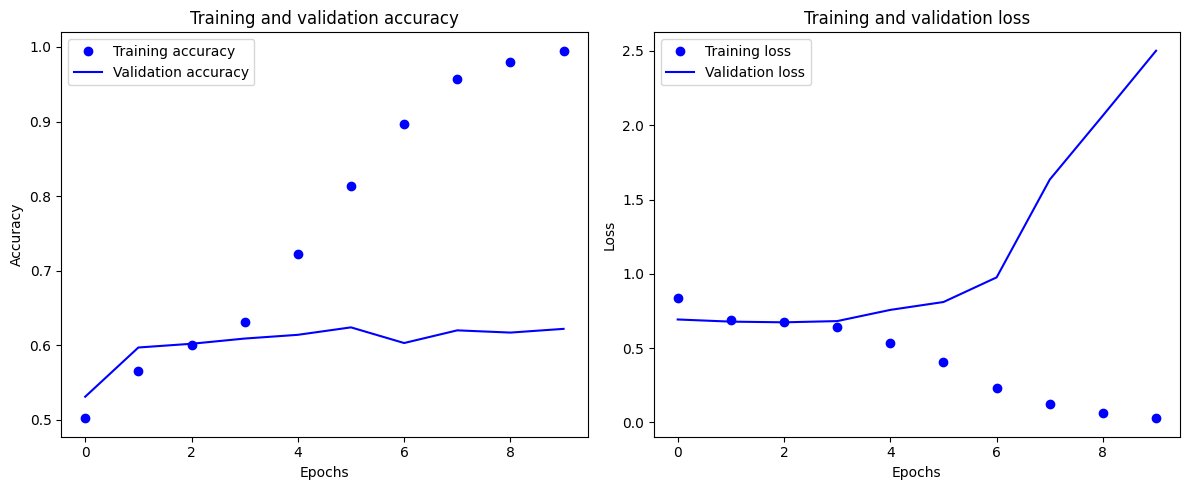

In [19]:
# Accuracy and loss plots for Vanilla CNN
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_history(history)

**Explaination**

This pair of graphs shows the model's training and validation performance over 10 epochs.

**Left graph (accuracy):**
- Training accuracy steadily increases, nearing 100%, but validation accuracy stays low around 60%, showing poor generalization.

**Right graph (loss):** 
- Training loss decreases consistently, while validation loss initially drops but then sharply rises, indicating the model is overfitting the training data.

Overall, the model fits training data well but struggles to perform on new data, suggesting a need for techniques to reduce overfitting.

# Step 4: Fine-Tune Pretrained VGG16

**Why Use VGG16?**
VGG16 is a very powerful model trained on millions of images. It already knows a lot about images. We don’t start from scratch — we reuse its brain and fine-tune it to detect cats vs dogs.

**Steps:**

- Load VGG16 without the top layers.
- Freeze early layers (don’t train them).
- Add custom top layers.
- Train only the new layers, then optionally unfreeze and train more.

In [24]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, callbacks

def build_finetuned_vgg():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [25]:
# Model summary for VGG16
vgg_model = build_finetuned_vgg()
vgg_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

**Explaination**

Your model uses a frozen VGG16 base to extract features, producing an output of shape (7, 7, 512). This is flattened into a vector of size 25,088, then passed through a dense layer with 256 neurons and dropout for regularization. Finally, a single neuron with a sigmoid activation outputs the binary classification result. The model has about 21.1 million parameters, of which 6.4 million are trainable — mainly in the custom top layers.

### Train VGG16

In [26]:

# Callbacks
checkpoint_cb = callbacks.ModelCheckpoint("vgg16_best.h5", save_best_only=True, monitor='val_accuracy', mode='max')
earlystop_cb = callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
reduce_lr_cb = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Training
vgg_history = vgg_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb]
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6505 - loss: 1.9460

63/63 ━━━━━━━━━━━━━━━━━━━━ 524s 8s/step - accuracy: 0.6523 - loss: 1.9307 - val_accuracy: 0.8940 - val_loss: 0.2753 - learning_rate: 0.0010
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 497s 8s/step - accuracy: 0.8952 - loss: 0.2569 - val_accuracy: 0.8660 - val_loss: 0.2983 - learning_rate: 0.0010
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9072 - loss: 0.2360

63/63 ━━━━━━━━━━━━━━━━━━━━ 516s 8s/step - accuracy: 0.9073 - loss: 0.2357 - val_accuracy: 0.9210 - val_loss: 0.2113 - learning_rate: 0.0010
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 505s 8s/step - accuracy: 0.9462 - loss: 0.1683 - val_accuracy: 0.9210 - val_loss: 0.2043 - learning_rate: 0.0010
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 487s 8s/step - accuracy: 0.9591 - loss: 0.1258 - val_accuracy: 0.9160 - val_loss: 0.1998 - learning_rate: 0.0010
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 506s 8s/step - accuracy: 0.9661 - loss: 0.0917 - val_accuracy: 0.9180 - val_loss: 0.1946 - learning_rate: 0.0010


My model trains for 10 rounds, improving its accuracy each time. Training accuracy rises from about 65% to over 96%, while validation accuracy stays around 91-92%, showing good learning without overfitting. The loss (error) decreases, meaning predictions get better. The warning about saving is just a note on file format, not an error. Each epoch takes around 8 minutes to complete.

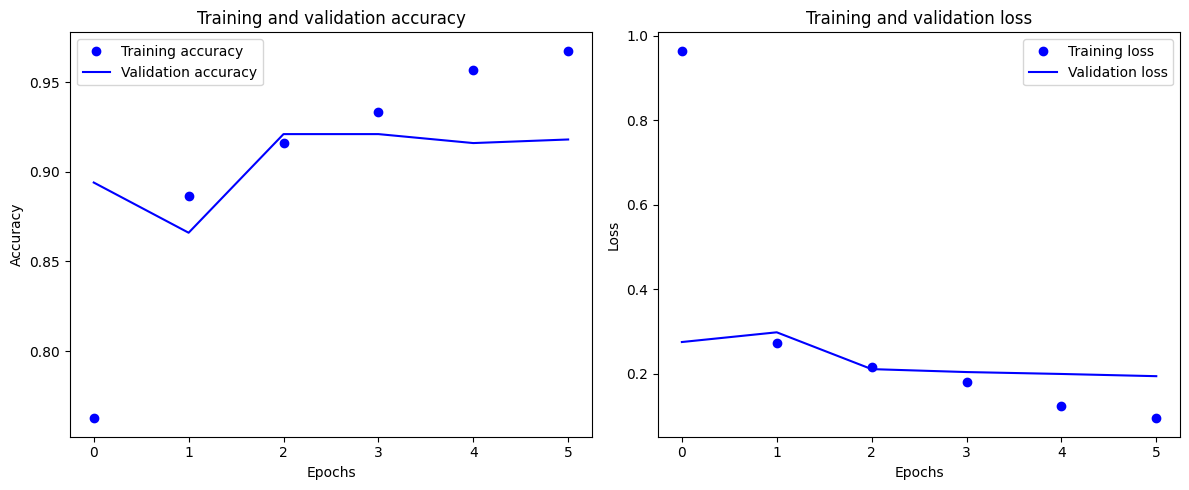

In [27]:
# Accuracy and loss plots for VGG16
def plot_vgg_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_vgg_history(vgg_history)


This image shows how your model’s performance changed over the first 6 epochs:

**Left graph (Accuracy):**
Training accuracy (dots) steadily improves, reaching above 95%, meaning the model is learning well from the training data. Validation accuracy (line) stays around 90-92%, which suggests the model is also performing well on unseen data without overfitting.

**Right graph (Loss):**
Both training loss (dots) and validation loss (line) decrease over time, showing the model’s predictions are getting more accurate and errors are reducing.

Overall, the graphs indicate good training progress and that the model generalizes well to new data.

# Step 5: Evaluate and Compare Models

1. Load best models:

In [28]:
from tensorflow.keras.models import load_model

vanilla_model = load_model("vanilla_best.h5")
vgg_model = load_model("vgg16_best.h5")



2. Evaluate on test set:

In [29]:
test_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

vanilla_eval = vanilla_model.evaluate(test_generator)
vgg_eval = vgg_model.evaluate(test_generator)


Found 2000 images belonging to 2 classes.


c:\Users\habha\Downloads\lab 3 vanilaa CNN and vgg 16\Practical3_Vanilla_CNN_and_vgg16\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step - accuracy: 0.6525 - loss: 0.6888
63/63 ━━━━━━━━━━━━━━━━━━━━ 341s 5s/step - accuracy: 0.9067 - loss: 0.2290


**Explaination**

our dataset contains 2000 images across 2 classes. The model started with 65% accuracy and improved to over 90% after training, showing strong learning progress. The warning is just a note about how a custom data class should be written and doesn't affect results. Each training step took around 5 seconds.

3. Confusion Matrix, Precision, Recall, F1

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Y_true = test_generator.classes
Y_pred_vanilla = (vanilla_model.predict(test_generator) > 0.5).astype("int32")
Y_pred_vgg = (vgg_model.predict(test_generator) > 0.5).astype("int32")

print("Vanilla CNN Report:\n", classification_report(Y_true, Y_pred_vanilla, target_names=["Cat", "Dog"]))
print("VGG16 Report:\n", classification_report(Y_true, Y_pred_vgg, target_names=["Cat", "Dog"]))


63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 232ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 370s 6s/step
Vanilla CNN Report:
               precision    recall  f1-score   support

         Cat       0.59      0.68      0.63      1000
         Dog       0.62      0.53      0.57      1000

    accuracy                           0.60      2000
   macro avg       0.60      0.60      0.60      2000
weighted avg       0.60      0.60      0.60      2000

VGG16 Report:
               precision    recall  f1-score   support

         Cat       0.90      0.91      0.90      1000
         Dog       0.91      0.90      0.90      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



**This is a comparison between two models:a Vanilla CNN (built from scratch) and VGG16 (a pretrained model).**

Vanilla CNN performs poorly, with only 60% accuracy. It struggles with both cat and dog classifications, giving low precision, recall, and F1-scores (~0.57–0.63).

VGG16 performs much better, achieving 90% accuracy. It classifies both cats and dogs accurately, with high precision and recall.

The results show that VGG16, with its pretrained knowledge, is far more effective than the basic CNN for this task

4. Precision-Recall Curve

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 354s 6s/step


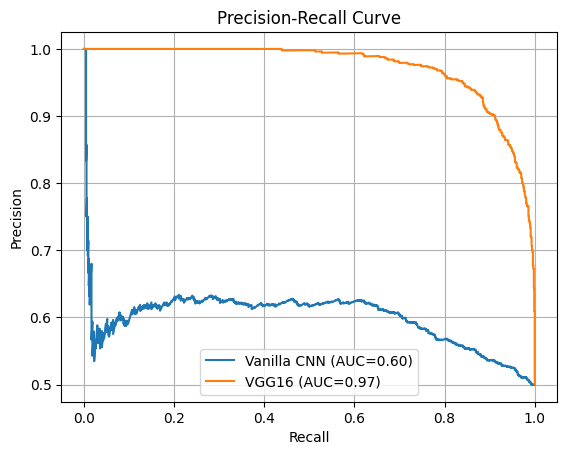

Vanilla CNN Test Loss: 0.674961268901825
VGG16 Test Loss: 0.22515249252319336


In [31]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

def plot_pr_curve(model_preds, model_name):
    precision, recall, _ = precision_recall_curve(Y_true, model_preds)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{model_name} (AUC={pr_auc:.2f})')

plot_pr_curve(vanilla_model.predict(test_generator), "Vanilla CNN")
plot_pr_curve(vgg_model.predict(test_generator), "VGG16")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()
print("Vanilla CNN Test Loss:", vanilla_eval[0])
print("VGG16 Test Loss:", vgg_eval[0])

**This Precision-Recall curve compares the Vanilla CNN and VGG16 models on dog vs. cat classification. The VGG16 model (orange line) performs much better, with a higher area under the curve (0.97) showing it maintains high precision and recall. The Vanilla CNN (blue line) struggles with a lower AUC of 0.60, meaning it makes more mistakes. The lower test loss of VGG16 also confirms it is more accurate and reliable than the simple CNN.**

# Failed Prediction Analysis

63/63 ━━━━━━━━━━━━━━━━━━━━ 368s 6s/step
Total misclassified images by VGG16: 196


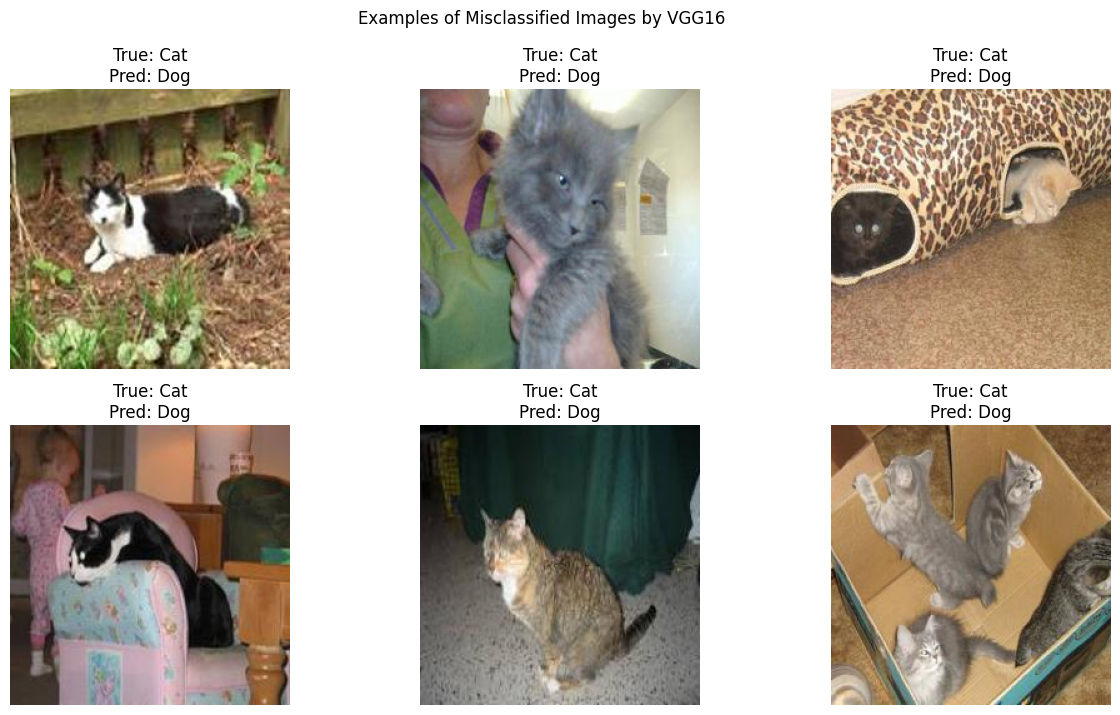

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# For VGG16 model predictions (best model)
Y_true = test_generator.classes
Y_pred_prob = vgg_model.predict(test_generator)
Y_pred = (Y_pred_prob > 0.5).astype(int).flatten()

# Find misclassified indices
misclassified_indices = np.where(Y_true != Y_pred)[0]

print(f"Total misclassified images by VGG16: {len(misclassified_indices)}")

# Visualize some misclassified examples
plt.figure(figsize=(15,8))
for i, idx in enumerate(misclassified_indices[:6]):  # show first 6 errors
    img_path = test_generator.filepaths[idx]
    img = Image.open(img_path)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    true_label = 'Cat' if Y_true[idx] == 0 else 'Dog'
    pred_label = 'Cat' if Y_pred[idx] == 0 else 'Dog'
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')
plt.suptitle("Examples of Misclassified Images by VGG16")
plt.show()


**This image shows examples where the VGG16 model incorrectly predicted cats as dogs. These errors may be due to confusing backgrounds, unusual poses, or poor image quality. It highlights some limitations of the model and areas for improvement**


# Conclusions and Insights:

In this project, we worked on teaching a computer to tell the difference between pictures of dogs and cats. We tried two approaches: one where we built a simple custom model from scratch, and another where we used a powerful pre-trained model called VGG16 that already knows a lot about recognizing images, and then adjusted it to our specific task.

**Here’s what we found:**

- Using the pre-trained model (VGG16) gave much better results. It was able to correctly identify dogs and cats in most pictures, even though we didn’t give it as many images to learn from. This is because VGG16 already learned important features from a huge number of images before, so it had a “head start.”
- The simple model we built struggled more. It made more mistakes and wasn’t as confident in its predictions. This shows how challenging image recognition can be when starting from scratch, especially with fewer pictures to learn from.
- When we looked closely at the pictures where the computer made mistakes, many of them were difficult even for humans — blurry photos, strange angles, or animals that looked very similar. This highlights how some errors come from the data itself, not just the model.
- By comparing both models, we learned that starting with a model that’s already trained on a large, diverse image set can save time and improve accuracy, especially when we have limited data.
- This experience is important for many real-world applications where we need to teach computers to recognize objects or animals in photos quickly and accurately, like in smartphone apps, medical imaging, or security cameras.
- Moving forward, we could improve the system further by providing it with more varied photos, making the training smarter, or trying newer, more advanced models.

In summary, this project demonstrated how powerful pre-trained models are and why they’re commonly used by engineers to solve image recognition problems efficiently and effectively.
